# Imports

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB # naive bayes
from sklearn import svm # support vector machines
from sklearn import linear_model # logistic regression
from sklearn import preprocessing
import xgboost as xgb # xgboost
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import optuna

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# Import all we need from nltk
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\casey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Data

What are the relevant label and feature columns?

In [2]:
# WHAT'S THE LABEL COLUMN
# WHAT'S THE TEXT COLUMN
tweets_df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Projects/Movie_Review_Sentiment_Analysis/data/Corona_tweets.csv', encoding='latin1')
tweets_df.head()

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral

# EDA

Get num rows and columns and column names

In [31]:
print('There are ', tweets_df.shape[0], ' rows.')
print('There are ', tweets_df.shape[1], ' columns.')
print('Column Names: ', tweets_df.columns)
print('Column Types: ', tweets_df.dtypes)

There are  44955  rows.
There are  6  columns.
Column Names:  Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
Column Types:  UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment         int64
dtype: object


Check for missing values in relevant features or labels

In [14]:
## CHECK FOR MISSING VALUES
tweets_df.info() # there are no missing values in the Sentiment or OriginalTweet columns which is what we care about

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


Check for weird values in label column

In [15]:
# There does appear to be a label imbalance, may have to address it
# There are also labels that should be combined. Extremely Positive -> P
# ositive, Extremely Negative -> Negative
tweets_df['Sentiment'].value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

In [20]:
## COMBINE THE LABELS
# Define a mapping dictionary
label_mapping = {
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
}

# Use .map() with the mapping dictionary, and fill missing values (for values not in the mapping)
# Values that don’t have a corresponding entry in the dictionary ('positive', 'neutral', etc.) will be turned into NaN. fillna(df['sentiment']) ensures that any unmapped values remain unchanged.
tweets_df['Sentiment'] = tweets_df['Sentiment'].map(label_mapping).fillna(tweets_df['Sentiment'])

In [21]:
## CHECK FOR MISSING VALUES
tweets_df.info() # there are no missing values in the Sentiment or OriginalTweet columns which is what we care about

## LOOK AT LABEL BALANCE

tweets_df['Sentiment'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


Sentiment
Positive    19592
Negative    17031
Neutral      8332
Name: count, dtype: int64

## Label Balance
### If Imbalanced
* Random Undersampling
* Use tree based methods
* Anomaly Detection if only two classes
* Class weights

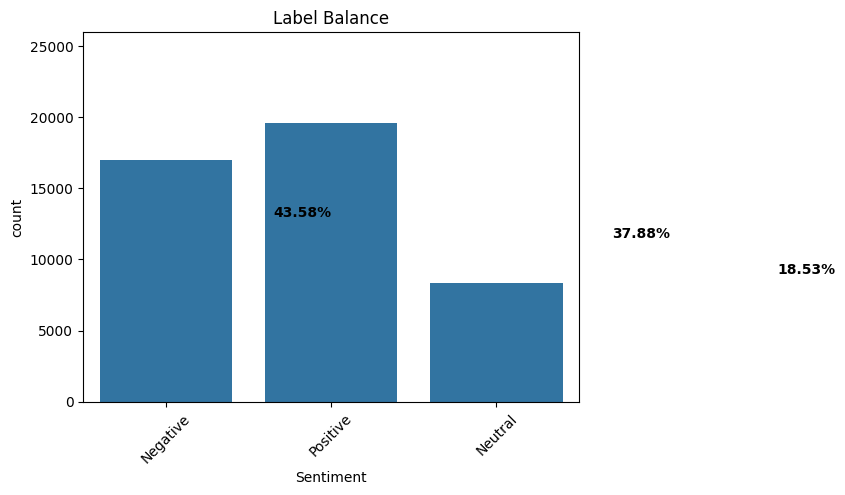

Positive percent is: 43.58
Negative percent is: 37.88
Neutral percent is: 18.53


In [22]:
# # percent of labels equal to 'Positive'
# positive_percent = round(tweets_df['Sentiment'].value_counts().iloc[0] / len(tweets_df.index) * 100, 2)

# # percent of labels equal to 'Negative'
# negative_percent = round(tweets_df['Sentiment'].value_counts().iloc[1] / len(tweets_df.index) * 100, 2)

# # percent of labels equal to 'Neutral'
# neutral_percent = round(tweets_df['Sentiment'].value_counts().iloc[2] / len(tweets_df.index) * 100, 2)

 
# sns.countplot(data=tweets_df, x='Sentiment')
# plt.ylim(0, 26000)
# plt.text(0.65, 13000, str(positive_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(2.7, 11500, str(negative_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(3.7, 9000, str(neutral_percent) + '%', size='medium', color='black', weight='semibold')
# plt.title('Label Balance')
# plt.xticks(rotation=45)
# plt.show()

# print("Positive percent is: " + str(positive_percent))
# print("Negative percent is: " + str(negative_percent))
# print("Neutral percent is: " + str(neutral_percent))

sns.countplot(data=tweets_df, x='Exited')
# plt.ylim(0, 26000)
# plt.text(0.65, 13000, str(positive_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(2.7, 11500, str(negative_percent) + '%', size='medium', color='black', weight='semibold')
# plt.text(3.7, 9000, str(neutral_percent) + '%', size='medium', color='black', weight='semibold')
plt.title('Label Balance')
plt.xticks(rotation=45)
plt.show()

Check for weird tweets to omit
* super short
* super long

In [ ]:
# Label percentages
label_counts = tweets_df['Seniment'].value_counts()
label_percentages = (label_counts / len(tweets_df)) * 100

# Print label counts and percentages
print("Label Counts:")
print(label_counts)
print("\nLabel Percentages (%):")
print(label_percentages)

In [37]:
# sort ascending by tweet length
# may want to omit really short tweets # tweets_df[tweets_df['OriginalTweet'].str.len() > 20]
tweets_df['OriginalTweet'].str.len().sort_values()#[:20]

24265     11
13574     11
39324     11
20670     11
19375     12
        ... 
236      349
4000     349
11281    360
28958    365
3001     378
Name: OriginalTweet, Length: 44955, dtype: int64

In [36]:
tweets_df.loc[23345].OriginalTweet

'An American living in  '

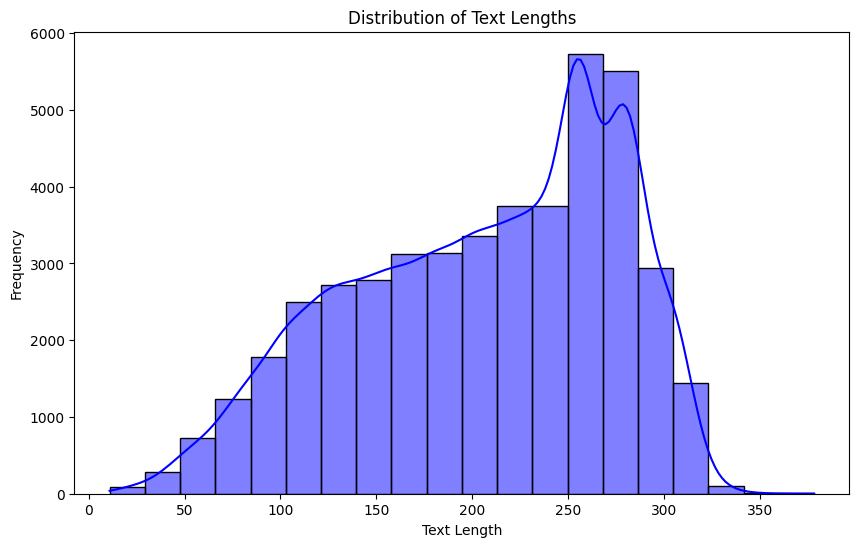

In [31]:
tweets_df['tweet_length'] = tweets_df['OriginalTweet'].str.len()

# Plot the distribution of text lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(tweets_df['tweet_length'], bins=20, kde=True, color='blue')  # KDE adds a smooth curve
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

## Normalization

In [10]:
# Normalize First

## CONVERT TO LOWERCASE
def to_lowercase(text):
    text = text.lower()
    return text

#df['review'] = df['review'].apply(to_lowercase)

# ------------------------------------------------------------------------------------------------ #
## REMOVE NUMBERS
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

#df['review'] = df['review'].apply(remove_numbers)

# ------------------------------------------------------------------------------------------------ #
## REMOVE PUNCTUATION
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

#df['review'] = df['review'].apply(remove_punctuations)

# ------------------------------------------------------------------------------------------------ #
## REMOVE SPECIAL CHARACTERS
def remove_special_chars(text):
    return re.sub('[^a-zA-Z]', ' ', text)

#df['review'] = df['review'].apply(remove_special_chars)

# ------------------------------------------------------------------------------------------------ #
## REMOVE UNNECESSARY WHITE SPACE
def remove_whitespace(text):
    return  " ".join(text.split())

#df['review'] = df['review'].apply(remove_whitespace)

# ------------------------------------------------------------------------------------------------ #
## REMOVE STOPWORDS

# create list of your own words to also remove
my_stopwords = ['br', 'b']

def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english') + my_stopwords
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

#df['review'] = df['review'].apply(remove_stopwords)


# ------------------------------------------------------------------------------------------------ #
## LEMMATIZATION
# usually preferred over stemming
# considers context (word part of speech)
# caring -> care

#lem_df = df.copy()

# Part of speech tagger function
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Instantiate lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    #word_tokens = word_tokenize(text)
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_review = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_review.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_review.append(lemmatizer.lemmatize(word, tag))
    lemmatized_review = " ".join(lemmatized_review)
    return lemmatized_review

#lem_df['review'] = lem_df['review'].apply(lemmatize_word)

# Twitter Specific Cleaning
def remove_hyperlinks(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', ' ', text)

def remove_hashtag_symbol(text):
    return re.sub(r'#', ' ', text)

def remove_retweet_text(text):
    return re.sub(r'^RT[\s]+', ' ', text)

# ---------------------------------------------------------------------------------------------------------------------------- #
## CUSTOM NORMALIZATION FUNCTION

# choose which preprocessing functions to use
# not using lemmatization or stemming since using a neural network
def custom_normalization(reviews):
    reviews = reviews.apply(to_lowercase)
    reviews = reviews.apply(remove_numbers)
    reviews = reviews.apply(remove_punctuations)
    reviews = reviews.apply(remove_special_chars)
    reviews = reviews.apply(remove_stopwords)
    reviews = reviews.apply(remove_hyperlinks)
    reviews = reviews.apply(remove_hashtag_symbol)
    reviews = reviews.apply(remove_retweet_text)
    reviews = reviews.apply(lemmatize_word)
    return reviews

tweets_df['OriginalTweet'] = custom_normalization(tweets_df['OriginalTweet'])

Check Tweet Length After Normalization

In [47]:
# sort ascending by tweet length
# may want to omit really short tweets # tweets_df[tweets_df['OriginalTweet'].str.len() > 20]
tweets_df['OriginalTweet'].str.len().sort_values()#[:20]

16208      0
39324      3
24265      3
33407      4
15845      6
        ... 
3184     272
10607    274
17489    275
12503    277
12825    278
Name: OriginalTweet, Length: 44955, dtype: int64

In [ ]:
tweets_df.loc[23345].OriginalTweet

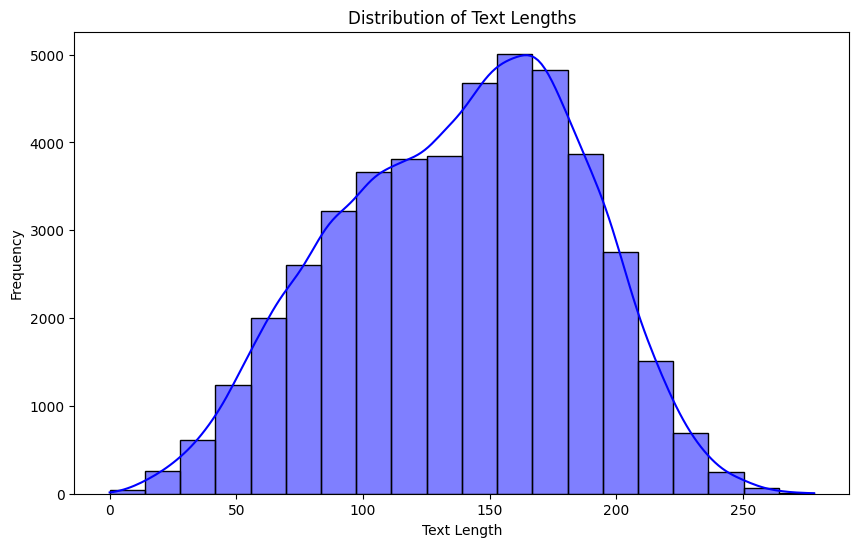

In [48]:
tweets_df['tweet_length'] = tweets_df['OriginalTweet'].str.len()

# Plot the distribution of text lengths using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(tweets_df['tweet_length'], bins=20, kde=True, color='blue')  # KDE adds a smooth curve
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

## Common Word Plots
* If common words between classes potentially remove them

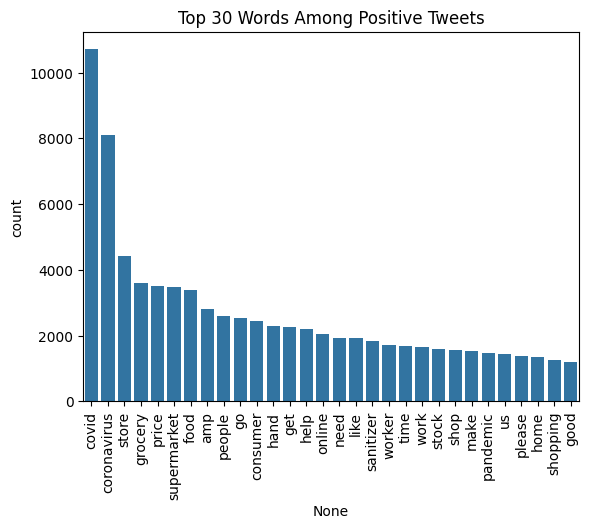

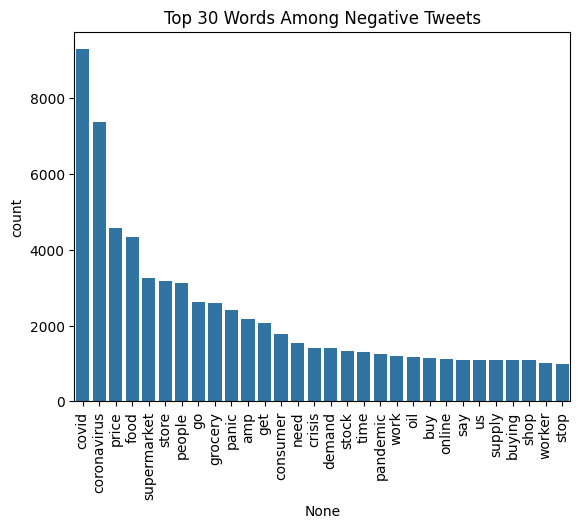

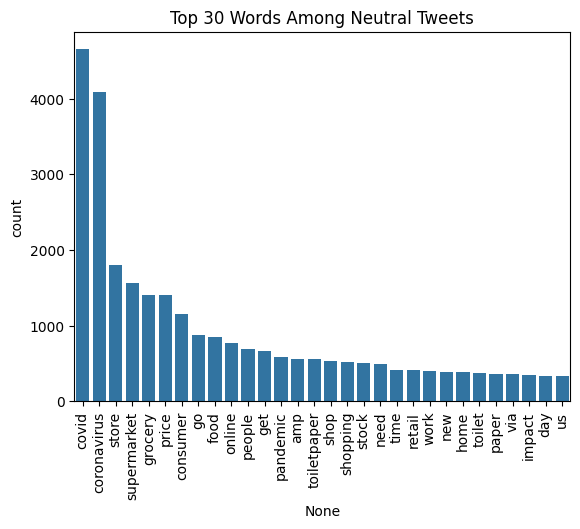

In [24]:
## GET WORD FREQUENCIES 

num_words = 30

pos_freq = tweets_df.iloc[:,1:][tweets_df.Sentiment == 'Positive'].OriginalTweet.str.split(expand=True).stack().value_counts()[0:num_words]
neg_freq = tweets_df.iloc[:,1:][tweets_df.Sentiment == 'Negative'].OriginalTweet.str.split(expand=True).stack().value_counts()[0:num_words]
nue_freq = tweets_df.iloc[:,1:][tweets_df.Sentiment == 'Neutral'].OriginalTweet.str.split(expand=True).stack().value_counts()[0:num_words]

# ---------------------------------------------------------------------------------------------------------------------------- #
## GET WORDS
pos_cols = pos_freq.index
neg_cols = neg_freq.index
nue_cols = nue_freq.index

# ---------------------------------------------------------------------------------------------------------------------------- #
## GENERATE PLOTS
sns.barplot(x=pos_cols, y=pos_freq)
plt.xticks(rotation=90)
plt.title('Top ' + str(num_words) + ' Words Among Positive Tweets')
plt.show()


sns.barplot(x=neg_cols, y=neg_freq)
plt.xticks(rotation=90)
plt.title('Top ' + str(num_words) + ' Words Among Negative Tweets')
plt.show()

sns.barplot(x=nue_cols, y=nue_freq)
plt.xticks(rotation=90)
plt.title('Top ' + str(num_words) + ' Words Among Neutral Tweets')
plt.show()

# Pre-Processing

* Label Mapping if necessary
* Train Test Split
* Custom Normalization on text if necessary
* Random Undersampling if necessary
* Tokenization and Vectorization of Text (TF-IDF) this is tuned, so not doing here

In [4]:
# WHAT'S THE LABEL COLUMN
# WHAT'S THE TEXT COLUMN
tweets_df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Projects/Movie_Review_Sentiment_Analysis/data/Corona_tweets.csv', encoding='latin1')

Label Mapping

In [5]:
tweets_df = pd.read_csv('C:/Users/casey/OneDrive/Documents/Data_Science/Projects/Movie_Review_Sentiment_Analysis/data/Corona_tweets.csv', encoding='latin1')
print('Before Mapping')
print(tweets_df.info())
print(tweets_df.Sentiment.value_counts())

# Define a mapping dictionary
label_mapping = {
    'Extremely Positive': 'Positive',
    'Extremely Negative': 'Negative'
}

# Use .map() with the mapping dictionary, and fill missing values (for values not in the mapping)
# Values that don’t have a corresponding entry in the dictionary ('positive', 'neutral', etc.) will be turned into NaN. fillna(df['sentiment']) ensures that any unmapped values remain unchanged.
tweets_df['Sentiment'] = tweets_df['Sentiment'].map(label_mapping).fillna(tweets_df['Sentiment'])

label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

tweets_df['Sentiment'] = tweets_df['Sentiment'].map(label_mapping_int).fillna(tweets_df['Sentiment'])

print('\nAfter Mapping')
print(tweets_df.info())
print(tweets_df.Sentiment.value_counts())
tweets = tweets_df.OriginalTweet
labels = tweets_df.Sentiment

Before Mapping
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB
None
Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

After Mapping
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Lo

Select label and text columns

In [6]:
X = tweets_df.OriginalTweet
y = tweets_df.Sentiment

Train_test_split
* If there is label imbalance ensure stratify is used

In [7]:
## Create train and test data
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=1, stratify=y) # using stratify to keep label percentage roughly the same since there is an imbalance

# Print percentage of each label in the training set
train_label_counts = np.bincount(y_train)
train_label_percentages = train_label_counts / len(y_train) * 100

print("Training Set Label Percentages:")
for label, percentage in enumerate(train_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

# Print percentage of each label in the testing set
test_label_counts = np.bincount(y_test)
test_label_percentages = test_label_counts / len(y_test) * 100

print("\nTesting Set Label Percentages:")
for label, percentage in enumerate(test_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")


## Set the input shape
train_input_shape=X_train.shape
test_input_shape=X_test.shape

# check shapes
print("The input shape for the training reviews is\n", train_input_shape) ## (30000)
print("The input shape for the testing reviews is\n", test_input_shape) ## (5000)

Training Set Label Percentages:
Label 0: 43.58%
Label 1: 37.89%
Label 2: 18.53%

Testing Set Label Percentages:
Label 0: 43.58%
Label 1: 37.88%
Label 2: 18.54%
The input shape for the training reviews is
 (35964,)
The input shape for the testing reviews is
 (8991,)


Random Undersampling if Necessary

In [8]:
train_df = pd.DataFrame()
train_df['train_tweets'] = X_train
train_df['train_labels'] = y_train

X = train_df[['train_tweets']] # Features
y = train_df['train_labels']  # Target/Labels

# Before undersampling
print('Original dataset class distribution:', Counter(y))

# Create the RandomUnderSampler object
rus = RandomUnderSampler(random_state=42) # can specify ratio you want as well

# Perform undersampling
X_res, y_res = rus.fit_resample(X, y)

# After undersampling
print('Resampled dataset class distribution:', Counter(y_res))
# Print percentage of each label in the testing set
test_label_counts = np.bincount(y_test)
test_label_percentages = test_label_counts / len(y_test) * 100

print("\nTesting Set Label Percentages:")
for label, percentage in enumerate(test_label_percentages):
    print(f"Label {label}: {percentage:.2f}%")

# Convert the resampled dataset back to DataFrame if needed
train_df_resampled = pd.DataFrame(X_res, columns=X.columns)
train_df_resampled['train_labels'] = y_res
print(train_df_resampled)

X_train = train_df_resampled['train_tweets']
y_train = train_df_resampled['train_labels']

Original dataset class distribution: Counter({0: 15674, 1: 13625, 2: 6665})
Resampled dataset class distribution: Counter({0: 6665, 1: 6665, 2: 6665})

Testing Set Label Percentages:
Label 0: 43.58%
Label 1: 37.88%
Label 2: 18.54%
                                            train_tweets  train_labels
36843  But I want to say thank you to all of the fron...             0
5281   In the interest of health safety at this time,...             0
11046  We've got some resources on those topics -- He...             0
37244  instead of standing on top of me on line at a ...             0
28863  The young lady from the supermarket has a good...             0
...                                                  ...           ...
19342  Which COVID-19-Related Consumer Behavior Shift...             2
43949  there is less competition for consumer attenti...             2
17974  @Dandydon1903 1. People gathering together, li...             2
36125  So glad IÃÂve never had to go to a supermark...   

Custom Normalization

In [11]:
# normalize reviews
train_tweets = custom_normalization(X_train)
test_tweets = custom_normalization(X_test)

Get number of tokens in training set, use to help determine max_featurs in tf-idf

In [12]:
def tokenize(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    return tokens

X_train_df = pd.DataFrame()
X_train_df['text'] = X_train

X_train_df['tokenized_text'] = X_train_df['text'].apply(tokenize)

# Flatten the tokenized lists into a single list
all_tokens = [token for sublist in X_train_df['tokenized_text'] for token in sublist]

# Print the first 10 tokens (optional, for checking)
print(all_tokens[:10])

# Get the total number of tokens
print(f'Total number of tokens: {len(all_tokens)}')

# To get unique tokens, use set
unique_tokens = set(all_tokens)
print(f'Number of unique tokens: {len(unique_tokens)}')

['But', 'I', 'want', 'to', 'say', 'thank', 'you', 'to', 'all', 'of']
Total number of tokens: 726574
Number of unique tokens: 60629


# Modeling

## XGBoost

### Baseline

* Evaluating on testing set to see initial accuracy
* Also check if class imbalance is an issue

In [60]:
# Establish tfidf vectorizer and random forest 
tfidf = TfidfVectorizer(max_features=10000)
clf = xgb.XGBClassifier(n_jobs=-1)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred_test = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

# Print classification report
report = classification_report(y_true=test_labels, y_pred=y_pred_test, target_names=target_names)
print(report)

Validation Macro F1 Score: 0.7137
              precision    recall  f1-score   support

    Positive       0.84      0.71      0.77      3918
    Negative       0.80      0.68      0.74      3406
     Neutral       0.51      0.85      0.64      1667

    accuracy                           0.72      8991
   macro avg       0.72      0.75      0.71      8991
weighted avg       0.76      0.72      0.73      8991

['Positive', 'Negative', 'Neutral']


Evaluating on training set to check if overfitting initially

In [62]:
# Evaluate on training set to see if overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")


# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

# Print classification report
report = classification_report(y_true=train_labels, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.8368
              precision    recall  f1-score   support

    Positive       0.88      0.81      0.84      6665
    Negative       0.88      0.79      0.84      6665
     Neutral       0.76      0.91      0.83      6665

    accuracy                           0.84     19995
   macro avg       0.84      0.84      0.84     19995
weighted avg       0.84      0.84      0.84     19995



Evaluate through cross val to also check potential overfitting on certain train/test split

In [57]:
# Establish tfidf vectorizer and random forest 
tfidf = TfidfVectorizer(max_features=10000)
clf = xgb.XGBClassifier(n_jobs=-1)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Perform cross-validation
scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro') # scoring can be accuracy, f1_macro, precision_macro, recall_macro 
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.74079313 0.74137972 0.73640501 0.73497173 0.73523592]
0.7377571012496265


### Hyperparameter Tuning w/o Class Weights

In [63]:
def xgb_objective(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    # Hyperparameters for TF-IDF
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.7 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)']  # Various ngram options
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options)
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 1000 and 10000

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range)  # Use eval carefully in trusted environments

    # Define the TF-IDF Vectorizer with hyperparameters
    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Hyperparameters for XGBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)  # Number of boosting rounds
    max_depth = trial.suggest_int('max_depth', 3, 30)  # Maximum depth of a tree
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  # Learning rate for shrinking the model
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # Subsample ratio of the training instance
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)  # Subsample ratio of columns when constructing each tree
    gamma = trial.suggest_float('gamma', 0, 5)  # Minimum loss reduction required to make a further partition on a leaf node

    # Create the XGBoost model with hyperparameters
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,  # Disable label encoding, to avoid warnings in newer versions
    )

    # Create a pipeline (TF-IDF + XGBoost)
    model = make_pipeline(tfidf, clf)

    # Perform cross-validation
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring can be accuracy, f1_macro, etc.
    accuracy = scores.mean()

    return accuracy

In [64]:
# Create Optuna study
study_xgb = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study_xgb.optimize(xgb_objective, n_trials=3)

# Output the best hyperparameters
print("Best hyperparameters: ", study_xgb.best_params)

[I 2024-09-27 15:19:48,308] A new study created in memory with name: no-name-392d6e55-e8a7-4b68-9607-883d570363dd
[W 2024-09-27 15:31:14,781] Trial 0 failed with parameters: {'max_df': 0.9176302905569795, 'min_df': 2, 'ngram_range': '(1, 3)', 'max_features': 3604, 'n_estimators': 143, 'max_depth': 27, 'learning_rate': 0.019404678189492364, 'subsample': 0.9780377761605528, 'colsample_bytree': 0.6347144994200508, 'gamma': 3.2435037944884315} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\casey\AppData\Local\Temp\ipykernel_25828\3324582047.py", line 44, in xgb_objective
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring can be accuracy, f1_macro, etc.
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

Check Underfitting. If it is underfitting, adjust param space
* Increase max_depth
* Increase n_estimators
* Increase learning rate
* Increase subsample
* Increase colsample_bytree
* Decrease/Remove gamma
* Potentially decrease/remove alpha or lambda regularization

Check model performance across classes. If there is a large difference
* Add class weights
* Random Undersampling/Oversampling

In [14]:
# Best hyperparameters from Optuna study
best_params = study_xgb.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

clf = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    random_state=42,
    n_jobs=-1
)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred_test = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=test_labels, y_pred=y_pred_test)
print(report)

Validation Macro F1 Score: 0.7939
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      3918
           1       0.82      0.80      0.81      3406
           2       0.73      0.74      0.73      1667

    accuracy                           0.81      8991
   macro avg       0.79      0.79      0.79      8991
weighted avg       0.81      0.81      0.81      8991



Check Overfitting. If it is overfitting, adjust param space
* Reduce max_depth
* Reduce n_estimators
* Reduce learning rate
* Reduce subsample
* Reduce colsample_bytree
* Increase gamma
* Potentially add alpha or lambda regularization

In [15]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=train_labels, y_pred=y_pred_train)
print(report)

Train Macro F1 Score: 0.8655
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     15674
           1       0.89      0.87      0.88     13625
           2       0.81      0.82      0.82      6665

    accuracy                           0.88     35964
   macro avg       0.86      0.87      0.87     35964
weighted avg       0.88      0.88      0.88     35964



[[3323  376  219]
 [ 440 2721  245]
 [ 212  227 1228]]


[Text(0, 0.5, '0: Positive'),
 Text(0, 1.5, '1: Negative'),
 Text(0, 2.5, '2: Neutral')]

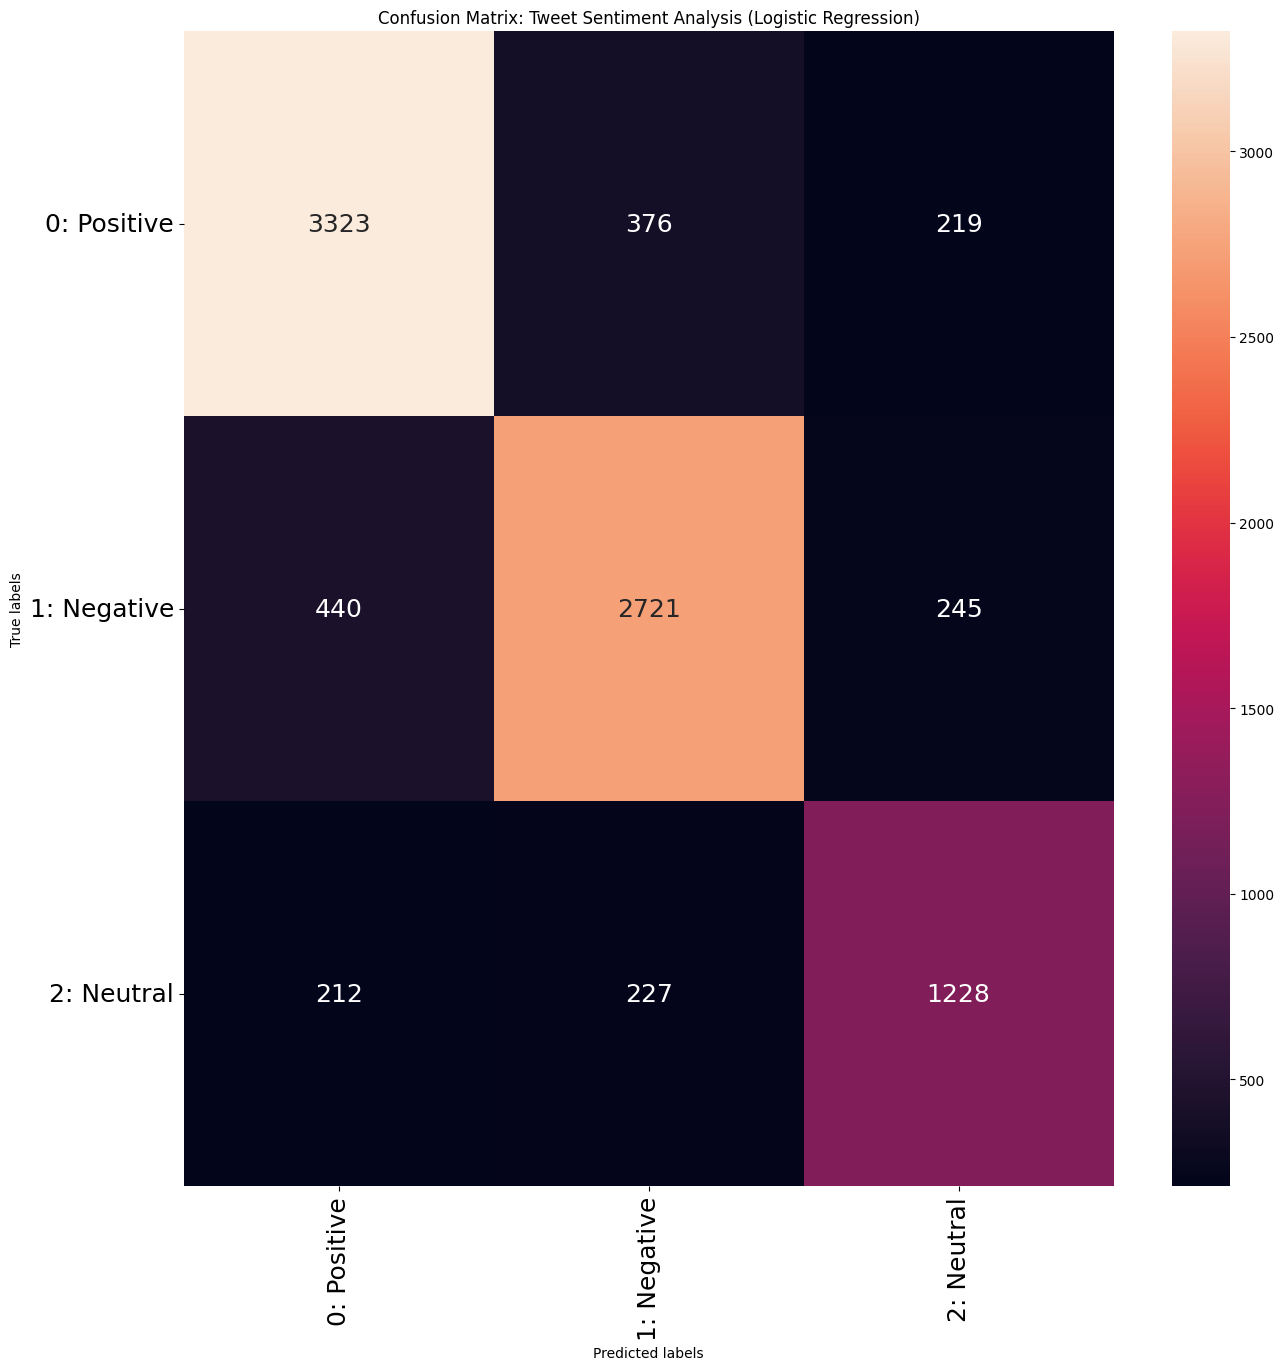

In [16]:
CM=confusion_matrix(y_pred=y_pred_test, y_true=test_labels)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (Logistic Regression)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)

### Hyperparameter Tuning w Class Weights

Two Options
* Tune class weights for each class (probably gives better performance, but requires more trials to tune)
* Get class weights from inverse label proportion (smaller proportion labels get higher weights)

XGBoost can handle binary class weights as a parameter, otherwise have to add separately. This example is three class. Look up binary class weight syntax.

In [43]:
def objective(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    # Hyperparameters for TF-IDF
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.7 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)']  # Various ngram options
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options)
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 1000 and 10000

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range) 

    # Define the TF-IDF Vectorizer with hyperparameters
    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Hyperparameters for XGBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)  # Number of boosting rounds
    max_depth = trial.suggest_int('max_depth', 3, 30)  # Maximum depth of a tree
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  # Learning rate for shrinking the model
    subsample = trial.suggest_float('subsample', 0.5, 1.0)  # Subsample ratio of the training instance
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)  # Subsample ratio of columns when constructing each tree
    gamma = trial.suggest_float('gamma', 0, 5)  # Minimum loss reduction required to make a further partition on a leaf node

    ## Two Options for Class Weights
    # ## Option 1
    # # Tune class weights for class imbalance (assuming 3 classes: 0, 1, and 2)
    # class_weight_0 = trial.suggest_float('class_weight_0', 0.5, 4.0)  # Class weight for class 0
    # class_weight_1 = trial.suggest_float('class_weight_1', 0.5, 4.0)  # Class weight for class 1
    # class_weight_2 = trial.suggest_float('class_weight_2', 0.5, 4.0)  # Class weight for class 2
    # class_weight_dict = {0: class_weight_0, 1: class_weight_1, 2: class_weight_2}

    ## Option 2
    # Calculate class weights based on proportions
    unique_classes = np.unique(train_labels)
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    # Convert class weights to a dictionary for easy access
    class_weight_dict = dict(zip(unique_classes, class_weights))

    # Create the XGBoost model with hyperparameters
    clf = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,  # Disable label encoding, to avoid warnings in newer versions
    )

    # Create a pipeline (TF-IDF + XGBoost)
    model = make_pipeline(tfidf, clf)

    # Calculate sample weights based on the class weights
    sample_weights = np.array([class_weight_dict[label] for label in train_labels])

    # Perform cross-validation
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro', params={'xgbclassifier__sample_weight': sample_weights})  # Scoring can be accuracy, f1_macro, etc.
    accuracy = scores.mean()

    return accuracy

In [ ]:
# Create Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study.optimize(objective, n_trials=1)

# Output the best hyperparameters
print('Best Trial: ', study.best_trial)
print("Best hyperparameters: ", study.best_params)

Check Underfitting. If it is underfitting, adjust param space
* Increase max_depth
* Increase n_estimators
* Increase learning rate
* Increase subsample
* Increase colsample_bytree
* Decrease/Remove gamma
* Potentially decrease/remove alpha or lambda regularization
* Increase class weights
* Try Random Undersampling on minority class

In [ ]:
# Best hyperparameters from Optuna study
best_params = study.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

clf = xgb.XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    random_state=42,
    n_jobs=-1
)

## Option 1
# class_weight_dict = {0: best_params['class_weight_0'], 1: best_params['class_weight_1'], 2: best_params['class_weight_2']}

## Option 2
# Calculate class weights based on proportions
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
# Convert class weights to a dictionary for easy access
class_weight_dict = dict(zip(unique_classes, class_weights))

sample_weights = np.array([class_weight_dict[label] for label in train_labels])

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels, params={'xgbclassifier__sample_weight': sample_weights})

# Evaluate on validation set
y_pred_test = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
report = classification_report(y_true=test_labels, y_pred=y_pred_test)
print(report)

Check Overfitting. If it is overfitting, adjust param space
* Reduce max_depth
* Reduce n_estimators
* Reduce learning rate
* Reduce subsample
* Reduce colsample_bytree
* Increase gamma
* Potentially add alpha or lambda regularization
* Decrease class weights on overperforming classes

In [ ]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")
report = classification_report(y_true=train_labels, y_pred=y_pred_train)
print(report)

In [ ]:
CM=confusion_matrix(y_pred=y_pred_test, y_true=test_labels)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (Logistic Regression)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)

## Random Forest

In [25]:
# normalize reviews
train_tweets = custom_normalization(train_tweets)
test_tweets = custom_normalization(test_tweets)

In [26]:
# Ways to determine max_features (words)
# - tune it using optuna, start with like a range of 10% to 30%
# - get the distribution of words eliminate non-contributors

all_train_words = []
for review in train_tweets:
    for word in review.split():
        all_train_words.append(word)
unique_train_words = set(all_train_words) # there are about 130000 unique words 
print(len(unique_train_words))

67827


### Baseline

* Evaluating on testing set to see initial accuracy
* Also check if class imbalance is an issue

In [28]:
# Establish tfidf vectorizer and random forest 
tfidf = TfidfVectorizer(max_features=10000)
clf = RandomForestClassifier(n_jobs=-1)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
report = classification_report(test_labels, y_pred)
print(report)

Validation Macro F1 Score: 0.7287
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      3914
           1       0.76      0.73      0.75      3447
           2       0.68      0.64      0.66      1630

    accuracy                           0.75      8991
   macro avg       0.73      0.73      0.73      8991
weighted avg       0.75      0.75      0.75      8991



Evaluating on training set to check if overfitting initially

In [29]:
# Evaluate on training set to see if overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")
report = classification_report(train_labels, y_pred_train)
print(report)

Train Macro F1 Score: 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15678
           1       1.00      1.00      1.00     13584
           2       1.00      1.00      1.00      6702

    accuracy                           1.00     35964
   macro avg       1.00      1.00      1.00     35964
weighted avg       1.00      1.00      1.00     35964



Evaluate through cross val to also check potential overfitting on certain train/test split

In [30]:
# Establish tfidf vectorizer and random forest 
tfidf = TfidfVectorizer(max_features=10000)
clf = RandomForestClassifier(n_jobs=-1)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Perform cross-validation
scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro') # scoring can be accuracy, f1_macro, precision_macro, recall_macro 
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.71208082 0.70780226 0.70709828 0.71421419 0.69842948]
0.7079250030261235


### Hyperparameter Tuning w/o Class Weights

In [31]:
def objective(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    # Hyperparameters for TF-IDF
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.5 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)'] # Unigrams, unigrams and bigrams, unigrams and bigrams and trigrams, bigrams, bigrams and trigrams, trigrams
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options) 
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 100 and 1000

    # Hyperparameters for Random Forest
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range)  

    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Create the RandomForest model with hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # Create a pipeline (TF-IDF + Random Forest)
    model = make_pipeline(tfidf, clf)

    # Perform cross-validation
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro') # scoring can be accuracy, f1_macro, precision_macro, recall_macro 
    accuracy = scores.mean()
    
    return accuracy

In [32]:
# Create Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study.optimize(objective, n_trials=25)

# Output the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-09-26 15:15:39,143] A new study created in memory with name: no-name-ae005743-6776-4234-9d7c-8b0ccc9f35a8


[I 2024-09-26 15:16:01,448] Trial 0 finished with value: 0.4512075769570372 and parameters: {'max_df': 0.8130866148167724, 'min_df': 4, 'ngram_range': '(1, 1)', 'max_features': 1788, 'n_estimators': 227, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.4512075769570372.
[I 2024-09-26 15:16:28,464] Trial 1 finished with value: 0.2504442898626331 and parameters: {'max_df': 0.7254503560052488, 'min_df': 1, 'ngram_range': '(3, 3)', 'max_features': 3624, 'n_estimators': 341, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4512075769570372.
[I 2024-09-26 15:17:54,654] Trial 2 finished with value: 0.5450174739179642 and parameters: {'max_df': 0.8064825641344127, 'min_df': 4, 'ngram_range': '(1, 2)', 'max_features': 2520, 'n_estimators': 341, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.5450174739179642.
[I 2024-09-26 15:18:35,625] Trial 3 finished with

Best hyperparameters:  {'max_df': 0.8331760410520005, 'min_df': 2, 'ngram_range': '(1, 2)', 'max_features': 1725, 'n_estimators': 466, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2}


Check Underfitting. If it is underfitting, adjust param space
* Increase max_depth
* Increase n_estimators
* Decrease min_samples_split
* Decrease min_samples_leaf

Check model performance across classes. If there is a large difference
* Add class weights
* Random Undersampling/Oversampling

In [33]:
# Best hyperparameters from Optuna study
best_params = study.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(test_labels, y_pred, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
report = classification_report(test_labels, y_pred)
print(report)

Validation Macro F1 Score: 0.5793
              precision    recall  f1-score   support

           0       0.60      0.86      0.71      3914
           1       0.76      0.63      0.69      3447
           2       0.67      0.23      0.34      1630

    accuracy                           0.66      8991
   macro avg       0.68      0.57      0.58      8991
weighted avg       0.67      0.66      0.63      8991



Check Overfitting. If it is overfitting, adjust param space
* Reduce max_depth
* Increase min_samples_split
* Increase min_samples_leaf
* Reduce n_estimators

In [34]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")
report = classification_report(train_labels, y_pred_train)
print(report)

Train Macro F1 Score: 0.6256
              precision    recall  f1-score   support

           0       0.64      0.91      0.75     15678
           1       0.83      0.69      0.75     13584
           2       0.73      0.25      0.38      6702

    accuracy                           0.70     35964
   macro avg       0.73      0.62      0.63     35964
weighted avg       0.73      0.70      0.68     35964



[[3354  473   87]
 [1167 2183   97]
 [1030  229  371]]


[Text(0, 0.5, '0: Positive'),
 Text(0, 1.5, '1: Negative'),
 Text(0, 2.5, '2: Neutral')]

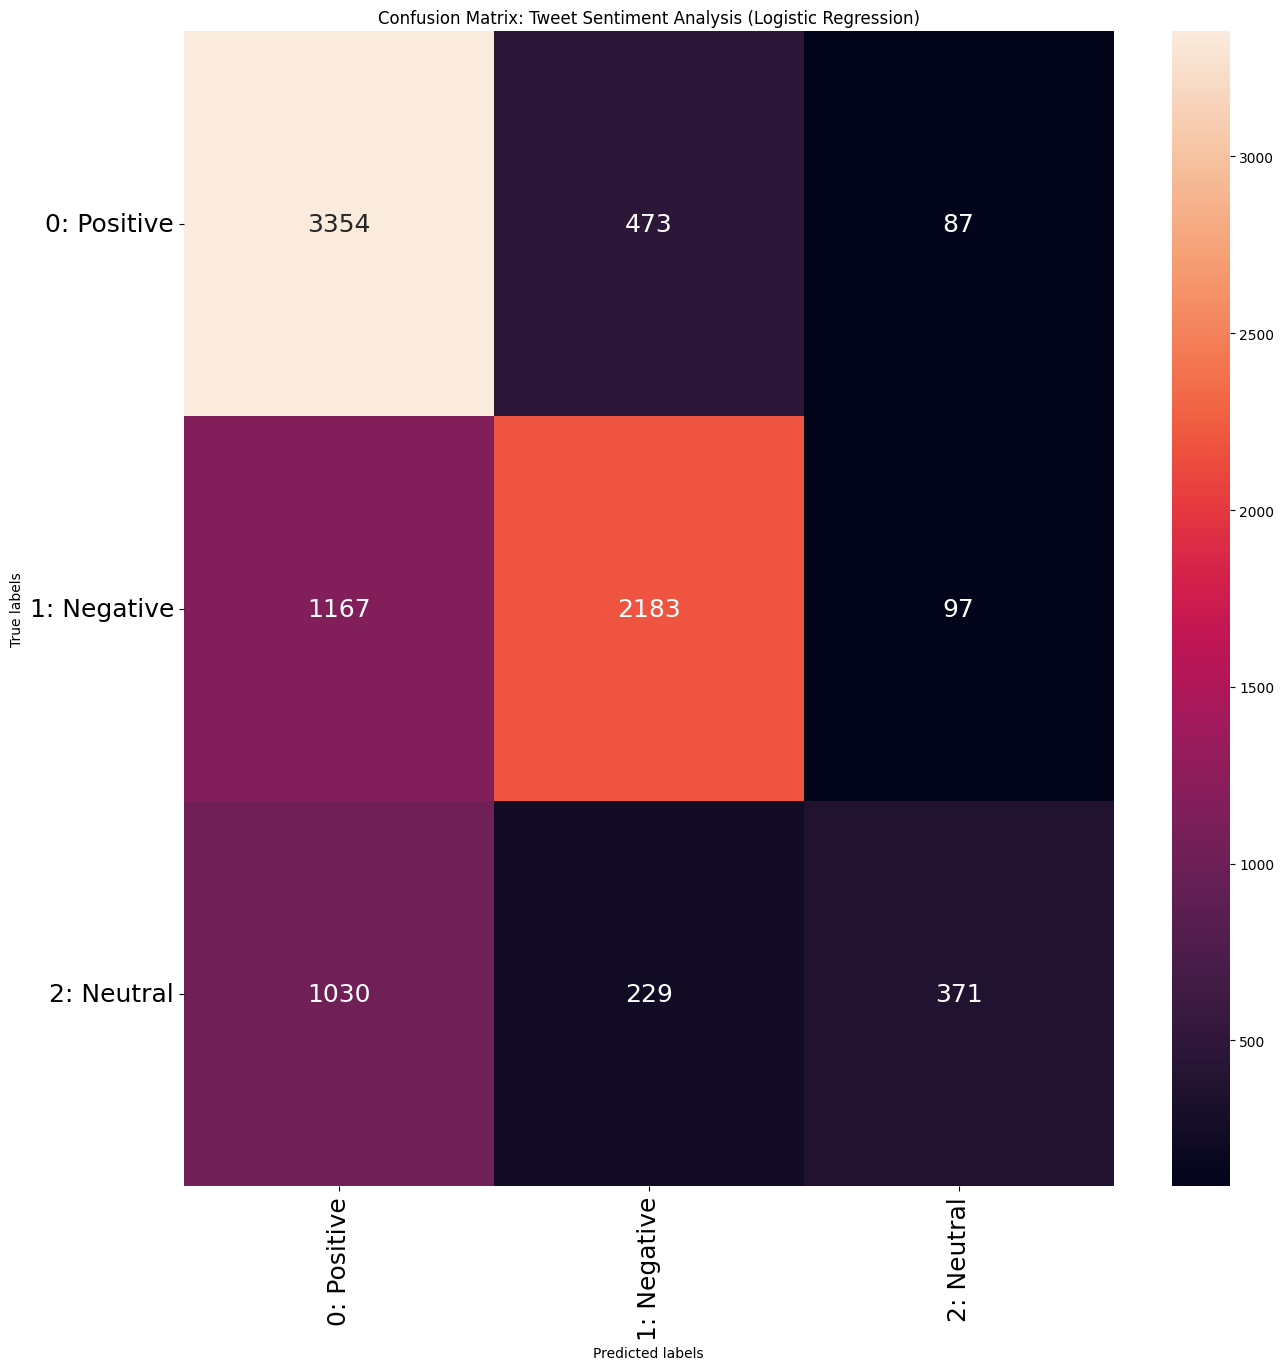

In [37]:
CM=confusion_matrix(y_pred=y_pred, y_true=test_labels)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (Logistic Regression)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)

### Hyperparameter Tuning w/Class Weights

Two Options
* Tune class weights for each class (probably gives better performance, but requires more trials to tune)
* Get class weights from inverse label proportion (smaller proportion labels get higher weights)

In [ ]:
def objective(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    # Hyperparameters for TF-IDF
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.5 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)'] # Unigrams, unigrams and bigrams, unigrams and bigrams and trigrams, bigrams, bigrams and trigrams, trigrams
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options) 
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 100 and 1000

    # Hyperparameters for Random Forest
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    ## Option 1
    # Suggest individual class weights for each class (assuming 3 classes)
    class_0_weight = trial.suggest_float('class_0_weight', 0.1, 10.0)  # Example: class 0
    class_1_weight = trial.suggest_float('class_1_weight', 0.1, 10.0)  # Example: class 1
    class_2_weight = trial.suggest_float('class_2_weight', 0.1, 10.0)  # Example: class 2
    # Create class_weight dictionary
    class_weight_dict = {0: class_0_weight, 1: class_1_weight, 2: class_2_weight}

    # ## Option 2
    # # Calculate class weights based on proportions
    # unique_classes = np.unique(train_labels)
    # class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    # # Convert class weights to a dictionary for easy access
    # class_weight_dict = dict(zip(unique_classes, class_weights))

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range)  

    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Create the RandomForest model with hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight_dict,
        random_state=42,
        n_jobs=-1
    )

    # Create a pipeline (TF-IDF + Random Forest)
    model = make_pipeline(tfidf, clf)

    # Perform cross-validation
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro') # scoring can be accuracy, f1_macro, precision_macro, recall_macro 
    accuracy = scores.mean()
    
    return accuracy

In [ ]:
# Create Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study.optimize(objective, n_trials=25)

# Output the best hyperparameters
print("Best hyperparameters: ", study.best_params)

Check Underfitting. If it is underfitting, adjust param space
* Increase max_depth
* Increase n_estimators
* Decrease min_samples_split
* Decrease min_samples_leaf
* Increase class weights
* Try Random Undersampling on minority class

In [ ]:
# Best hyperparameters from Optuna study
best_params = study.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

## Option 1
# class_weight_dict = {0: best_params['class_weight_0'], 1: best_params['class_weight_1'], 2: best_params['class_weight_2']}

## Option 2
# Calculate class weights based on proportions
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
# Convert class weights to a dictionary for easy access
class_weight_dict = dict(zip(unique_classes, class_weights))

clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)


# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred_test = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
report = classification_report(y_true=test_labels, y_pred=y_pred_test)
print(report)

Check Overfitting. If it is overfitting, adjust param space
* Reduce max_depth
* Increase min_samples_split
* Increase min_samples_leaf
* Reduce n_estimators
* Decrease class weights on overperforming classes

In [ ]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")
report = classification_report(y_true=train_labels, y_pred=y_pred_train)
print(report)

In [ ]:
CM=confusion_matrix(y_pred=y_pred, y_true=test_labels)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (Logistic Regression)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)

## Logistic Regression

### Baseline

* Evaluating on testing set to see initial accuracy
* Also check if class imbalance is an issue

In [14]:
# Establish tfidf vectorizer and logistic regression
tfidf = TfidfVectorizer(max_features=10000)
clf = LogisticRegression(max_iter=1000, n_jobs=-1)  # You can adjust the hyperparameters as needed

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, y_train)

# Evaluate on the validation set
y_pred_test = model.predict(X_test)

# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_test, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

# Generate and print the classification report
report = classification_report(y_true=y_test, y_pred=y_pred_test, target_names=target_names)
print(report)

Validation Macro F1 Score: 0.6879
              precision    recall  f1-score   support

    Positive       0.85      0.66      0.74      3918
    Negative       0.73      0.69      0.71      3406
     Neutral       0.49      0.81      0.61      1667

    accuracy                           0.70      8991
   macro avg       0.69      0.72      0.69      8991
weighted avg       0.74      0.70      0.71      8991



Evaluating on training set to check if overfitting initially

In [15]:
# Evaluate on training set to see if overfitting
y_pred_train = model.predict(X_train)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_train, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

report = classification_report(y_true=y_train, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.7860
              precision    recall  f1-score   support

    Positive       0.86      0.75      0.80      6665
    Negative       0.77      0.76      0.76      6665
     Neutral       0.74      0.85      0.79      6665

    accuracy                           0.79     19995
   macro avg       0.79      0.79      0.79     19995
weighted avg       0.79      0.79      0.79     19995



Evaluate through cross val to also check potential overfitting on certain train/test split

In [16]:
# Establish tfidf vectorizer and log reg classifier
tfidf = TfidfVectorizer(max_features=10000)
clf = LogisticRegression(max_iter=1000, n_jobs=-1)  # You can adjust the hyperparameters as needed

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, y_train)

# Perform cross-validation
scores = cross_val_score(model, train_tweets, y_train, cv=5, n_jobs=-1, scoring='f1_macro') # scoring can be accuracy, f1_macro, precision_macro, recall_macro 
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.75077532 0.75075752 0.72856339 0.74589526 0.74657484]
0.744513265888878


### Hyperparameter Tuning w/o Class Weights

In [17]:
def objective_logreg(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.7 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)']  # Various ngram options
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options)
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 1000 and 10000

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range)  # Use eval carefully in trusted environments

    # Define the TF-IDF Vectorizer with hyperparameters
    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Hyperparameters for Logistic Regression
    C_value = trial.suggest_float('C_value', 0.01, 10.0)  # Inverse regularization strength
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])  # Solver for optimization
    # Conditional selection of penalty based on solver
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])  # liblinear supports both l1 and l2
    else:
        penalty = 'l2'  # lbfgs only supports l2

    # Create the Logistic Regression model with hyperparameters
    clf = LogisticRegression(
        C=C_value,
        solver=solver,
        penalty=penalty,
        max_iter=1000,  # Ensure convergence
        n_jobs=-1,
        random_state=42
    )

    # Create a pipeline (TF-IDF + Logistic Regression)
    model = make_pipeline(tfidf, clf)

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring can be accuracy, f1_macro, etc.
    accuracy = scores.mean()

    return accuracy

In [18]:
# Create Optuna study
study_logreg = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study_logreg.optimize(objective_logreg, n_trials=5)

# Output the best hyperparameters
print("Best hyperparameters: ", study_logreg.best_params)
print("Best trial: ", study_logreg.best_trial)

[I 2024-09-29 14:39:59,957] A new study created in memory with name: no-name-0573fb90-3cc7-4717-91b2-7735e1c717cf
[I 2024-09-29 14:40:09,255] Trial 0 finished with value: 0.7490499226744987 and parameters: {'max_df': 0.7244955000712863, 'min_df': 2, 'ngram_range': '(1, 1)', 'max_features': 2601, 'C_value': 9.441628301802295, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7490499226744987.
[I 2024-09-29 14:40:24,021] Trial 1 finished with value: 0.5507173839829492 and parameters: {'max_df': 0.7241566411446586, 'min_df': 4, 'ngram_range': '(2, 2)', 'max_features': 2179, 'C_value': 5.252433341057498, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7490499226744987.
[I 2024-09-29 14:40:32,067] Trial 2 finished with value: 0.7616677608132825 and parameters: {'max_df': 0.9364505178406568, 'min_df': 3, 'ngram_range': '(1, 1)', 'max_features': 4733, 'C_value': 3.8688779400425424, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 2 with value: 0.7616677608132825.
[I 2024-09-29 14:40:5

Best hyperparameters:  {'max_df': 0.9364505178406568, 'min_df': 3, 'ngram_range': '(1, 1)', 'max_features': 4733, 'C_value': 3.8688779400425424, 'solver': 'liblinear', 'penalty': 'l2'}
Best trial:  FrozenTrial(number=2, state=1, values=[0.7616677608132825], datetime_start=datetime.datetime(2024, 9, 29, 14, 40, 24, 29992), datetime_complete=datetime.datetime(2024, 9, 29, 14, 40, 32, 62549), params={'max_df': 0.9364505178406568, 'min_df': 3, 'ngram_range': '(1, 1)', 'max_features': 4733, 'C_value': 3.8688779400425424, 'solver': 'liblinear', 'penalty': 'l2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_df': FloatDistribution(high=1.0, log=False, low=0.7, step=None), 'min_df': IntDistribution(high=5, log=False, low=1, step=1), 'ngram_range': CategoricalDistribution(choices=('(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)')), 'max_features': IntDistribution(high=10000, log=False, low=1000, step=1), 'C_value': FloatDistribution(high=10.0, log=False, 

Check Underfitting. If it is underfitting, adjust param space
* Increase C to decrease regularization
* Set penalty to None

Check model performance across classes. If there is a large difference
* Add class weights
* Random Undersampling/Oversampling

In [19]:
# Best hyperparameters from Optuna study
best_params = study_logreg.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

clf = LogisticRegression(
        C=best_params['C_value'],
        solver=best_params['solver'],
        penalty=best_params['penalty'],
        max_iter=1000,  # Ensure convergence
        n_jobs=-1,
        random_state=42
    )

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(X_train, y_train)

# Evaluate on validation set
y_pred_test = model.predict(X_test)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_test, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=y_test, y_pred=y_pred_test, target_names=target_names)
print(report)

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


Validation Macro F1 Score: 0.7491
              precision    recall  f1-score   support

    Positive       0.86      0.74      0.79      3918
    Negative       0.81      0.76      0.78      3406
     Neutral       0.56      0.82      0.67      1667

    accuracy                           0.76      8991
   macro avg       0.74      0.77      0.75      8991
weighted avg       0.79      0.76      0.77      8991



Check Overfitting. If it is overfitting, adjust param space
* Increase C, to increase regularization
* Use PCA
* Reduce n-gram value

In [20]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=y_train, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=y_train, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.7885
              precision    recall  f1-score   support

    Positive       0.80      0.80      0.80      6665
    Negative       0.85      0.71      0.78      6665
     Neutral       0.73      0.85      0.79      6665

    accuracy                           0.79     19995
   macro avg       0.80      0.79      0.79     19995
weighted avg       0.80      0.79      0.79     19995



[[2904  431  583]
 [ 358 2574  474]
 [ 133  162 1372]]


[Text(0, 0.5, '0: Positive'),
 Text(0, 1.5, '1: Negative'),
 Text(0, 2.5, '2: Neutral')]

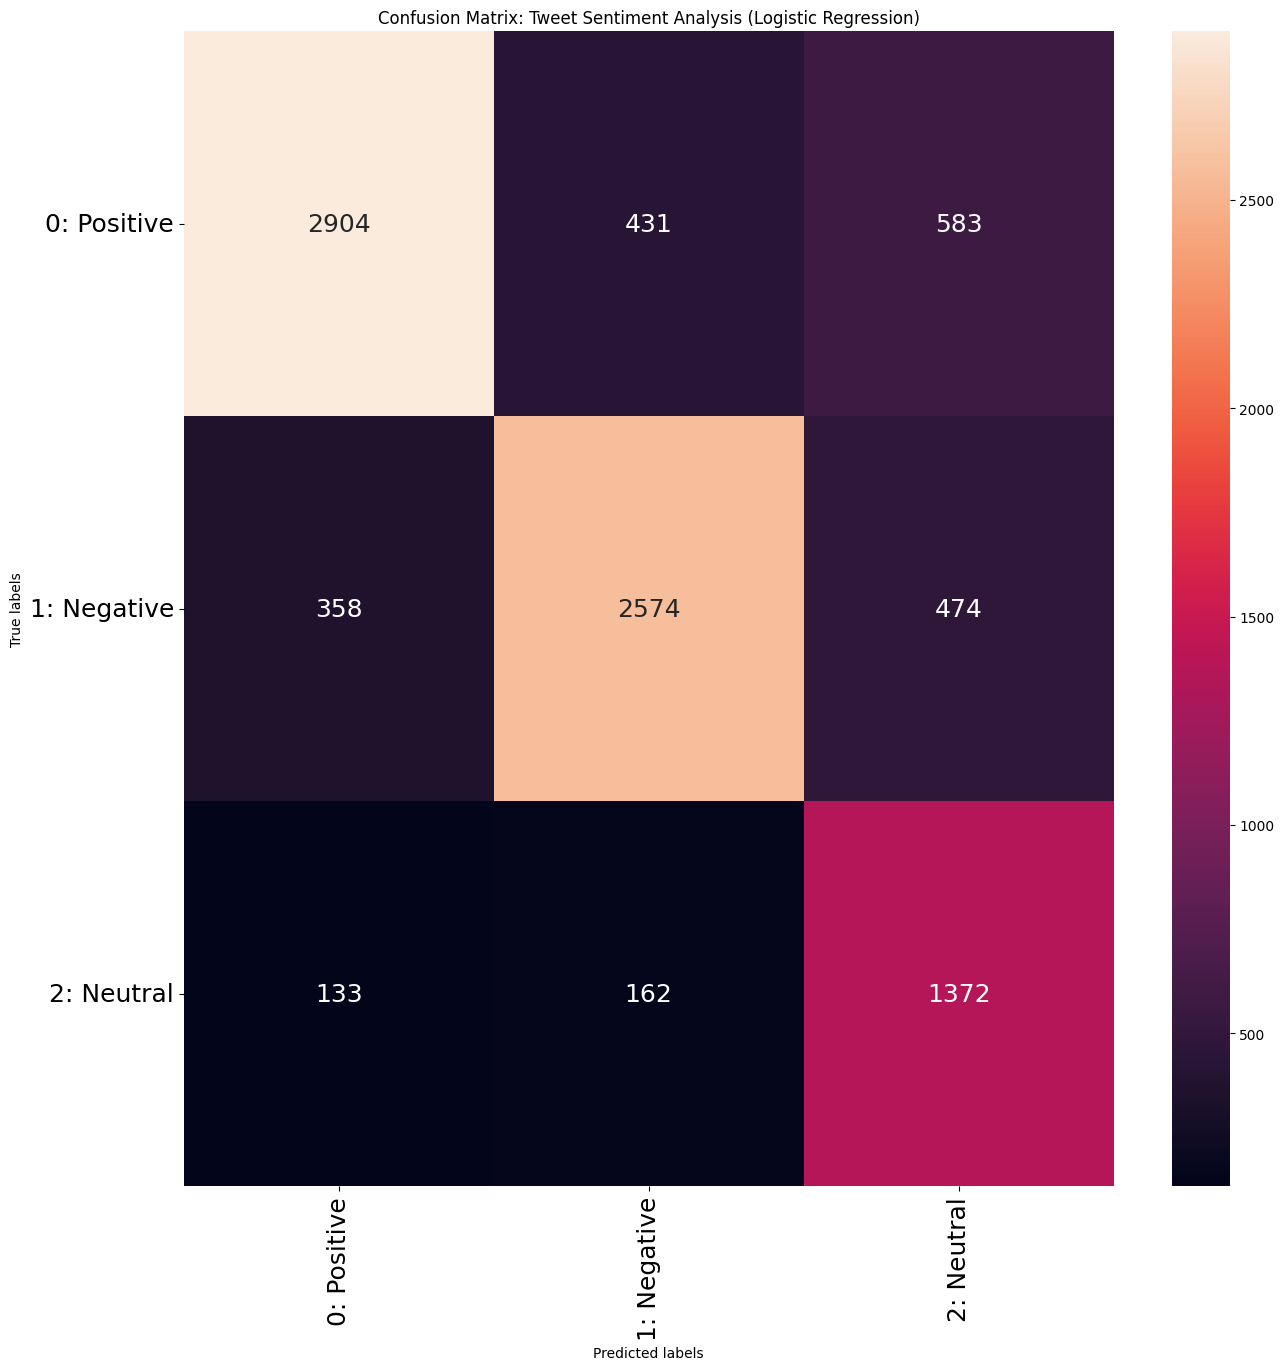

In [21]:
CM=confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (Logistic Regression)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)

### Hyperparameter Tuning w Class Weights

In [95]:
def objective_logreg(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.7 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)']  # Various ngram options
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options)
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 1000 and 10000

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range)  # Use eval carefully in trusted environments

    # Define the TF-IDF Vectorizer with hyperparameters
    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Hyperparameters for Logistic Regression
    C_value = trial.suggest_float('C_value', 0.01, 10.0)  # Inverse regularization strength
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])  # Solver for optimization
    # Conditional selection of penalty based on solver
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])  # liblinear supports both l1 and l2
    else:
        penalty = 'l2'  # lbfgs only supports l2

    ## Two Options for Class Weights
    ## Option 1
    # Tune class weights for class imbalance (assuming 3 classes: 0, 1, and 2)
    class_weight_0 = trial.suggest_float('class_weight_0', 0.5, 4.0)  # Class weight for class 0
    class_weight_1 = trial.suggest_float('class_weight_1', 0.5, 4.0)  # Class weight for class 1
    class_weight_2 = trial.suggest_float('class_weight_2', 0.5, 4.0)  # Class weight for class 2
    class_weight_dict = {0: class_weight_0, 1: class_weight_1, 2: class_weight_2}

    # ## Option 2
    # # Calculate class weights based on proportions
    # unique_classes = np.unique(train_labels)
    # class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
    # # Convert class weights to a dictionary for easy access
    # class_weight_dict = dict(zip(unique_classes, class_weights))

    # Create the Logistic Regression model with hyperparameters
    clf = LogisticRegression(
        C=C_value,
        solver=solver,
        penalty=penalty,
        max_iter=1000,  # Ensure convergence
        class_weight=class_weight_dict,
        n_jobs=-1,
        random_state=42
    )

    # Create a pipeline (TF-IDF + Logistic Regression)
    model = make_pipeline(tfidf, clf)

    # Perform cross-validation
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring can be accuracy, f1_macro, etc.
    accuracy = scores.mean()

    return accuracy

In [96]:
# Create Optuna study
study_logreg = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study_logreg.optimize(objective_logreg, n_trials=10)

# Output the best hyperparameters
print("Best hyperparameters: ", study_logreg.best_params)

[I 2024-09-27 15:57:55,375] A new study created in memory with name: no-name-b6609180-4f99-4b8f-9167-95d476665031
[I 2024-09-27 15:58:08,173] Trial 0 finished with value: 0.7109800985955643 and parameters: {'max_df': 0.9925792067135869, 'min_df': 1, 'ngram_range': '(1, 2)', 'max_features': 8652, 'C_value': 2.2425307465491904, 'solver': 'lbfgs', 'class_weight_0': 2.761106439382587, 'class_weight_1': 1.1982880903365802, 'class_weight_2': 3.5871982869813737}. Best is trial 0 with value: 0.7109800985955643.
[I 2024-09-27 15:58:22,141] Trial 1 finished with value: 0.7135182777420275 and parameters: {'max_df': 0.7509055911004731, 'min_df': 1, 'ngram_range': '(1, 3)', 'max_features': 5786, 'C_value': 7.396339195666147, 'solver': 'lbfgs', 'class_weight_0': 3.069928428494129, 'class_weight_1': 3.5398910500386003, 'class_weight_2': 3.86123135090338}. Best is trial 1 with value: 0.7135182777420275.
[I 2024-09-27 15:58:27,161] Trial 2 finished with value: 0.32086663981964836 and parameters: {'max_

Best hyperparameters:  {'max_df': 0.9482592949334688, 'min_df': 3, 'ngram_range': '(1, 3)', 'max_features': 4138, 'C_value': 3.7827696370896886, 'solver': 'lbfgs', 'class_weight_0': 3.4923380918905838, 'class_weight_1': 1.9396113407993727, 'class_weight_2': 1.913721379559539}


Check Underfitting. If it is underfitting, adjust param space
* Increase C to decrease regularization
* Set penalty to None
* Increase class weights

Check model performance across classes. If there is a large difference
* Add class weights
* Random Undersampling/Oversampling

In [101]:
# Best hyperparameters from Optuna study
best_params = study_logreg.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

if best_params['solver'] == 'lbfgs':
    best_params['penalty'] = 'l2'

## Option 1
class_weight_dict = {0: best_params['class_weight_0'], 1: best_params['class_weight_1'], 2: best_params['class_weight_2']}

# ## Option 2
# # Calculate class weights based on proportions
# unique_classes = np.unique(train_labels)
# class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
# # Convert class weights to a dictionary for easy access
# class_weight_dict = dict(zip(unique_classes, class_weights))

clf = LogisticRegression(
        C=best_params['C_value'],
        solver=best_params['solver'],
        penalty=best_params['penalty'],
        max_iter=1000,  # Ensure convergence,
        class_weight=class_weight_dict,
        n_jobs=-1,
        random_state=42
    )

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred_test= model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=test_labels, y_pred=y_pred_test, target_names=target_names)
print(report)

Validation Macro F1 Score: 0.7247
              precision    recall  f1-score   support

    Positive       0.78      0.79      0.79      3918
    Negative       0.81      0.68      0.74      3406
     Neutral       0.57      0.74      0.65      1667

    accuracy                           0.74      8991
   macro avg       0.72      0.74      0.72      8991
weighted avg       0.75      0.74      0.74      8991



Check Overfitting. If it is overfitting, adjust param space
* Increase C, to increase regularization
* Use PCA
* Reduce n-gram value
* Reduce class weights

In [102]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=train_labels, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.8770
              precision    recall  f1-score   support

    Positive       0.84      0.95      0.89      6665
    Negative       0.91      0.83      0.87      6665
     Neutral       0.89      0.85      0.87      6665

    accuracy                           0.88     19995
   macro avg       0.88      0.88      0.88     19995
weighted avg       0.88      0.88      0.88     19995



[[3097  363  458]
 [ 603 2325  478]
 [ 246  181 1240]]


[Text(0, 0.5, '0: Positive'),
 Text(0, 1.5, '1: Negative'),
 Text(0, 2.5, '2: Neutral')]

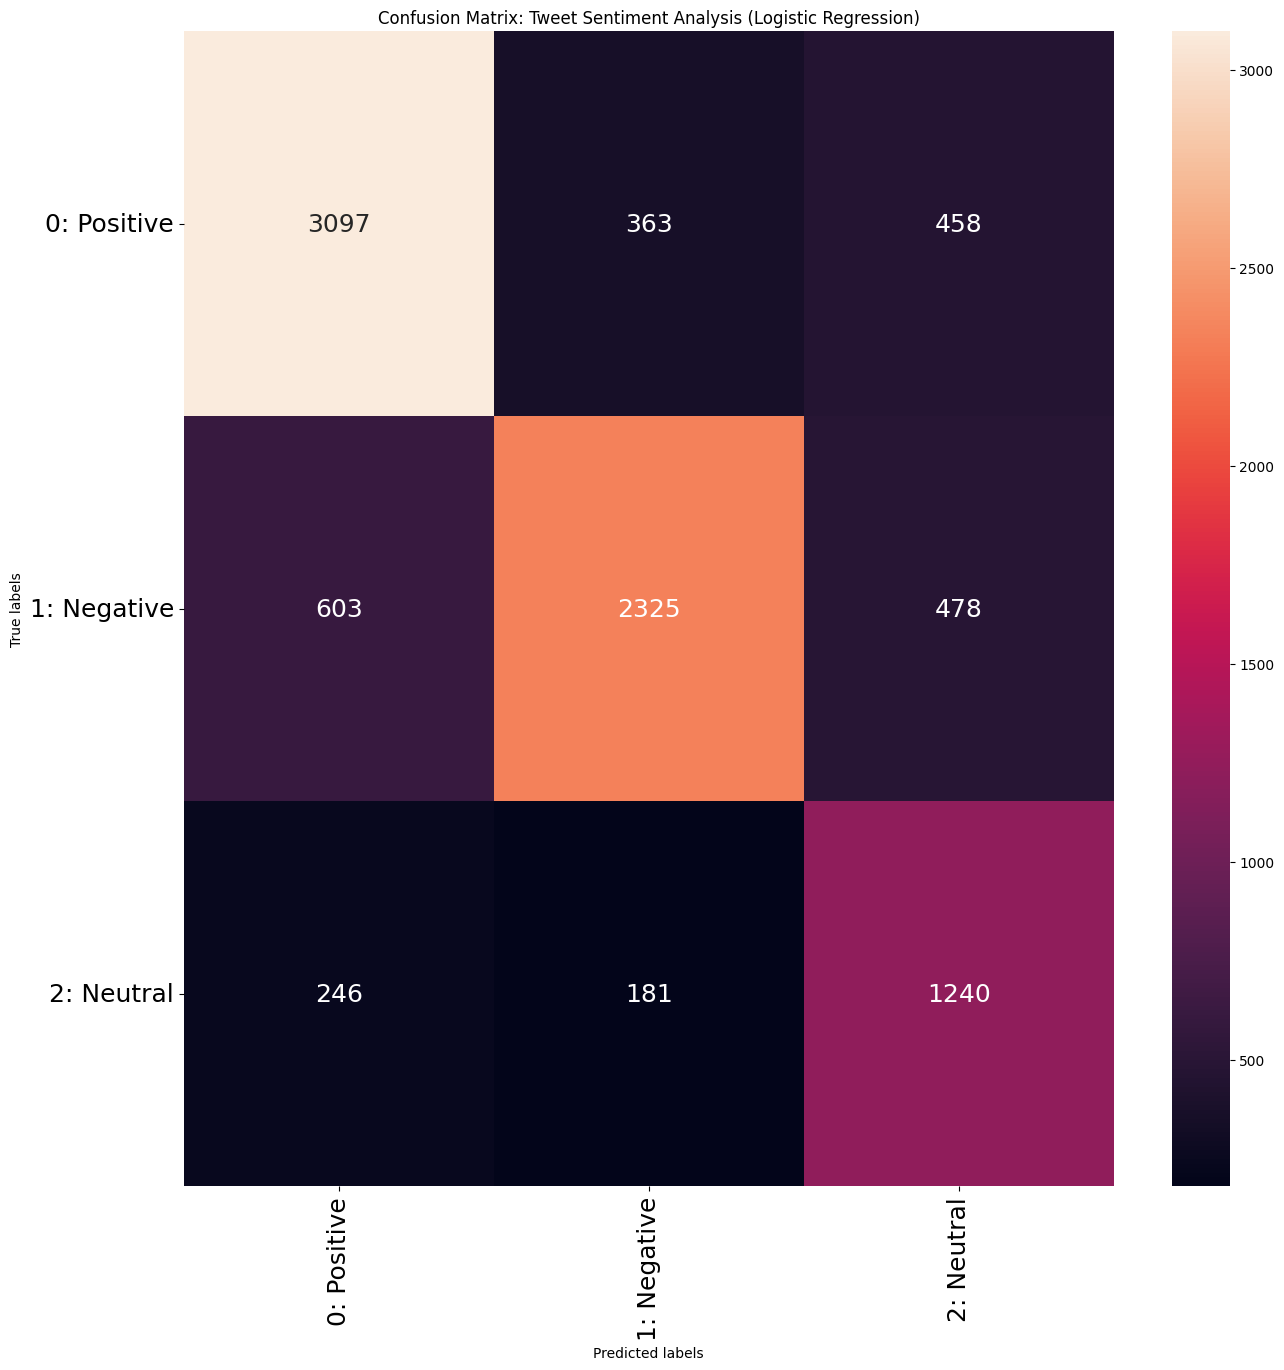

In [103]:
CM=confusion_matrix(y_pred=y_pred_test, y_true=test_labels)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (Logistic Regression)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)

## KNN

KNN Doesn't inherently accept class weights, so typically just use undersampling

### Baseline

* Evaluating on testing set to see initial accuracy
* Also check if class imbalance is an issue

In [11]:
# Establish tfidf vectorizer and KNN
tfidf = TfidfVectorizer(max_features=1000)
clf = KNeighborsClassifier(n_neighbors=5)  # You can adjust the hyperparameters as needed

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on the validation set
y_pred_test = model.predict(test_tweets)

# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

# Generate and print the classification report
report = classification_report(y_true=test_labels, y_pred=y_pred_test, target_names=target_names)
print(report)

Validation Macro F1 Score: 0.2142
              precision    recall  f1-score   support

    Positive       0.72      0.08      0.15      3918
    Negative       0.65      0.10      0.17      3406
     Neutral       0.19      0.93      0.32      1667

    accuracy                           0.25      8991
   macro avg       0.52      0.37      0.21      8991
weighted avg       0.60      0.25      0.19      8991



Evaluating on training set to check if overfitting initially

In [12]:
# Evaluate on training set to see if overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]

report = classification_report(y_true=train_labels, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.3897
              precision    recall  f1-score   support

    Positive       0.76      0.19      0.30      6665
    Negative       0.77      0.20      0.32      6665
     Neutral       0.38      0.96      0.55      6665

    accuracy                           0.45     19995
   macro avg       0.64      0.45      0.39     19995
weighted avg       0.64      0.45      0.39     19995



Evaluate through cross val to also check potential overfitting on certain train/test split

In [13]:
# Establish tfidf vectorizer and log reg classifier
tfidf = TfidfVectorizer(max_features=1000)
clf = KNeighborsClassifier(n_neighbors=5)  # You can adjust the hyperparameters as needed

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Perform cross-validation
scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro') # scoring can be accuracy, f1_macro, precision_macro, recall_macro 
accuracy = scores.mean()
print(scores)
print(accuracy)

[0.25890034 0.26459076 0.26339595 0.26122093 0.26173823]
0.26196924235501223


### Hyperparameter Tuning w/o PCA

In [14]:
def objective_knn(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.7 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)']  # Various ngram options
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options)
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 1000 and 10000

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range)  # Use eval carefully in trusted environments

    # Define the TF-IDF Vectorizer with hyperparameters
    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Hyperparameters for KNN
    n_neighbors = trial.suggest_int('n_neighbors', 3, 15)  # Number of neighbors
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Weight function used in prediction
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])  # Algorithm used to compute nearest neighbors
    p = trial.suggest_int('p', 1, 2)  # Power parameter for the Minkowski metric (1 for Manhattan, 2 for Euclidean)

    # Create the KNN model with hyperparameters
    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p
    )

    # Create a pipeline (TF-IDF + Logistic Regression)
    model = make_pipeline(tfidf, clf)

    # Perform cross-validation
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring can be accuracy, f1_macro, etc.
    accuracy = scores.mean()

    return accuracy

In [15]:
# Create Optuna study
study_knn = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study_knn.optimize(objective_knn, n_trials=10)

# Output the best hyperparameters
print("Best hyperparameters: ", study_knn.best_params)
print("Best trial: ", study_knn.best_trial)

[I 2024-09-28 09:14:51,703] A new study created in memory with name: no-name-c9c62d59-24df-4e8f-aac0-79ac070d293c
[I 2024-09-28 09:15:06,835] Trial 0 finished with value: 0.196092518593102 and parameters: {'max_df': 0.9943824867525113, 'min_df': 3, 'ngram_range': '(1, 1)', 'max_features': 5334, 'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}. Best is trial 0 with value: 0.196092518593102.
[I 2024-09-28 09:15:30,985] Trial 1 finished with value: 0.3720118804652515 and parameters: {'max_df': 0.8469204441288637, 'min_df': 3, 'ngram_range': '(2, 3)', 'max_features': 7229, 'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'p': 2}. Best is trial 1 with value: 0.3720118804652515.
[I 2024-09-28 09:15:47,078] Trial 2 finished with value: 0.3784079593494039 and parameters: {'max_df': 0.7331303159440113, 'min_df': 3, 'ngram_range': '(2, 3)', 'max_features': 3813, 'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}. Best is trial 2 with va

Best hyperparameters:  {'max_df': 0.7331303159440113, 'min_df': 3, 'ngram_range': '(2, 3)', 'max_features': 3813, 'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}
Best trial:  FrozenTrial(number=2, state=1, values=[0.3784079593494039], datetime_start=datetime.datetime(2024, 9, 28, 9, 15, 30, 987243), datetime_complete=datetime.datetime(2024, 9, 28, 9, 15, 47, 77310), params={'max_df': 0.7331303159440113, 'min_df': 3, 'ngram_range': '(2, 3)', 'max_features': 3813, 'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_df': FloatDistribution(high=1.0, log=False, low=0.7, step=None), 'min_df': IntDistribution(high=5, log=False, low=1, step=1), 'ngram_range': CategoricalDistribution(choices=('(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)')), 'max_features': IntDistribution(high=10000, log=False, low=1000, step=1), 'n_neighbors': IntDistribution(high=15, log=Fals

Check Underfitting. If it is underfitting, adjust param space
* Dimensionality Reduction, use SVD if TFIDF

Check model performance across classes. If there is a large difference
* Add class weights
* Random Undersampling/Oversampling

In [17]:
# Best hyperparameters from Optuna study
best_params = study_knn.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

# Create the KNN model with hyperparameters
clf = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    algorithm=best_params['algorithm'],
    p=best_params['p']
)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred_test = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=test_labels, y_pred=y_pred_test, target_names=target_names)
print(report)

c:\Users\casey\anaconda3\envs\ml\Lib\site-packages\sklearn\neighbors\_base.py:584: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Validation Macro F1 Score: 0.3554
              precision    recall  f1-score   support

    Positive       0.51      0.32      0.40      3918
    Negative       0.51      0.27      0.36      3406
     Neutral       0.21      0.60      0.32      1667

    accuracy                           0.36      8991
   macro avg       0.41      0.40      0.36      8991
weighted avg       0.45      0.36      0.37      8991



Check Overfitting. If it is overfitting, adjust param space
* Dimensionality Reduction
* Use distance weighting, weights = trial.suggest_categorical('weights', ['distance'])  # Use distance weighting

In [18]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=train_labels, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.4737
              precision    recall  f1-score   support

    Positive       0.50      0.40      0.44      6665
    Negative       0.60      0.37      0.45      6665
     Neutral       0.43      0.68      0.53      6665

    accuracy                           0.48     19995
   macro avg       0.51      0.48      0.47     19995
weighted avg       0.51      0.48      0.47     19995



[[1260  653 2005]
 [ 791  933 1682]
 [ 406  258 1003]]


[Text(0, 0.5, '0: Positive'),
 Text(0, 1.5, '1: Negative'),
 Text(0, 2.5, '2: Neutral')]

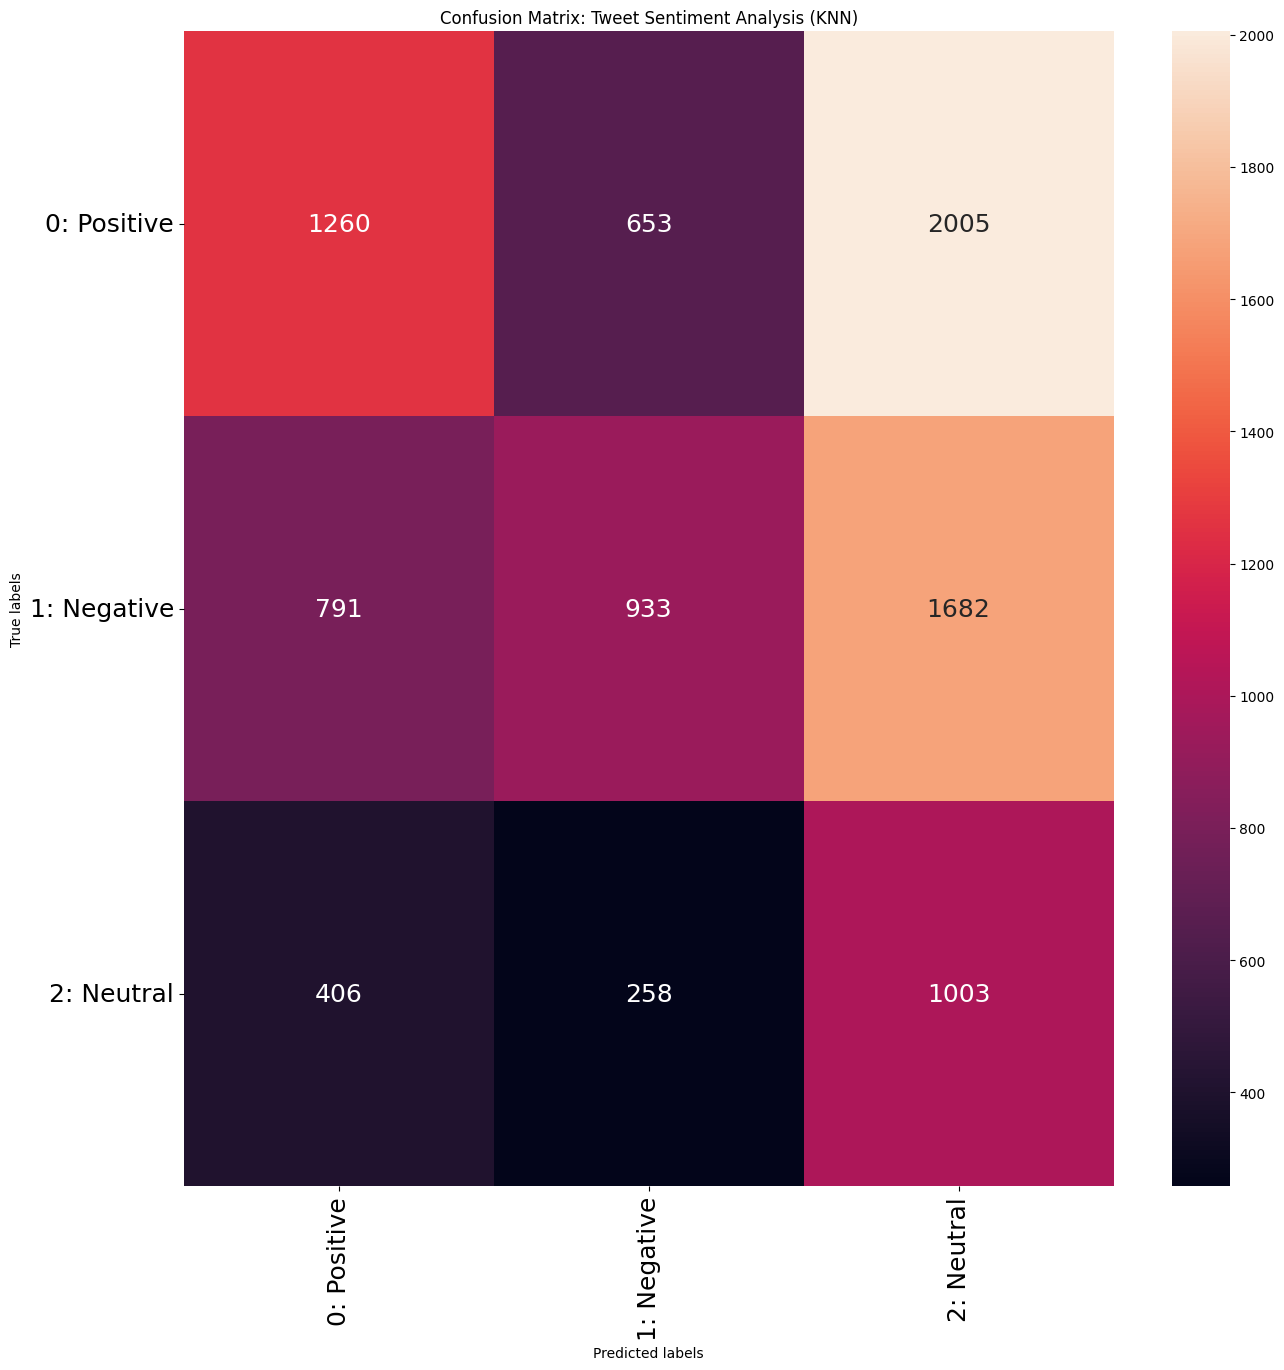

In [20]:
CM=confusion_matrix(y_pred=y_pred_test, y_true=test_labels)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (KNN)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)

### Hyperparameter Tuning w PCA

In [24]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [26]:
def objective_knn_svd(trial):
    # Define TF-IDF Vectorizer (hyperparameters can be optimized too if needed)
    max_df = trial.suggest_float('max_df', 0.7, 1.0)  # max_df between 0.7 and 1.0
    min_df = trial.suggest_int('min_df', 1, 5)  # min_df between 1 and 5
    ngram_options = ['(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)']  # Various ngram options
    ngram_range = trial.suggest_categorical('ngram_range', ngram_options)
    max_features = trial.suggest_int('max_features', 1000, 10000)  # max_features between 1000 and 10000

    # Convert string back to tuple for the vectorizer
    ngram_range_tuple = eval(ngram_range)  # Use eval carefully in trusted environments

    # Define the TF-IDF Vectorizer with hyperparameters
    tfidf = TfidfVectorizer(max_df=max_df,
                            min_df=min_df,
                            ngram_range=ngram_range_tuple,
                            max_features=max_features)

    # Hyperparameters for KNN
    n_neighbors = trial.suggest_int('n_neighbors', 3, 15)  # Number of neighbors
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Weight function used in prediction
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])  # Algorithm used to compute nearest neighbors
    p = trial.suggest_int('p', 1, 2)  # Power parameter for the Minkowski metric (1 for Manhattan, 2 for Euclidean)

    # Hyperparameters for Truncated SVD (Dimensionality Reduction)
    n_components = trial.suggest_int('n_components', 50, min(max_features, 500))  # Number of components for SVD

    # Define Truncated SVD for dimensionality reduction
    svd = TruncatedSVD(n_components=n_components)

    # Create the KNN model with hyperparameters
    clf = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        p=p
    )

    # Create a pipeline (TF-IDF + Logistic Regression)
    model = make_pipeline(tfidf, svd, clf)

    # Perform cross-validation
    scores = cross_val_score(model, train_tweets, train_labels, cv=5, n_jobs=-1, scoring='f1_macro')  # Scoring can be accuracy, f1_macro, etc.
    accuracy = scores.mean()

    return accuracy

In [27]:
# Create Optuna study
study_knn_svd = optuna.create_study(direction='maximize')

# Optimize the study, trying 50 trials (you can increase this for better results)
study_knn_svd.optimize(objective_knn_svd, n_trials=10)

# Output the best hyperparameters
print("Best hyperparameters: ", study_knn_svd.best_params)
print("Best trial: ", study_knn_svd.best_trial)

[I 2024-09-28 09:27:34,235] A new study created in memory with name: no-name-0b9fcaa1-39a6-4c06-bf60-503fdb3b859d
[I 2024-09-28 09:28:37,079] Trial 0 finished with value: 0.4972531798132692 and parameters: {'max_df': 0.8323591028909513, 'min_df': 2, 'ngram_range': '(1, 2)', 'max_features': 9922, 'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 1, 'n_components': 51}. Best is trial 0 with value: 0.4972531798132692.
[I 2024-09-28 09:30:56,194] Trial 1 finished with value: 0.424081080871867 and parameters: {'max_df': 0.9825784110420732, 'min_df': 3, 'ngram_range': '(2, 2)', 'max_features': 4271, 'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'p': 1, 'n_components': 232}. Best is trial 0 with value: 0.4972531798132692.
[I 2024-09-28 09:34:41,730] Trial 2 finished with value: 0.4347139765287976 and parameters: {'max_df': 0.7901158622399211, 'min_df': 2, 'ngram_range': '(1, 2)', 'max_features': 3154, 'n_neighbors': 12, 'weights': 'uniform', 'algorithm':

Best hyperparameters:  {'max_df': 0.8323591028909513, 'min_df': 2, 'ngram_range': '(1, 2)', 'max_features': 9922, 'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 1, 'n_components': 51}
Best trial:  FrozenTrial(number=0, state=1, values=[0.4972531798132692], datetime_start=datetime.datetime(2024, 9, 28, 9, 27, 34, 237901), datetime_complete=datetime.datetime(2024, 9, 28, 9, 28, 37, 77396), params={'max_df': 0.8323591028909513, 'min_df': 2, 'ngram_range': '(1, 2)', 'max_features': 9922, 'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'p': 1, 'n_components': 51}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_df': FloatDistribution(high=1.0, log=False, low=0.7, step=None), 'min_df': IntDistribution(high=5, log=False, low=1, step=1), 'ngram_range': CategoricalDistribution(choices=('(1, 1)', '(1, 2)', '(1, 3)', '(2, 2)', '(2, 3)', '(3, 3)')), 'max_features': IntDistribution(high=10000, log=False, low=1000, step=1), 'n_neighbo

In [28]:
# Best hyperparameters from Optuna study
best_params = study_knn_svd.best_params

# Train final model with the best hyperparameters
tfidf = TfidfVectorizer(max_features=best_params['max_features'],
                        min_df=best_params['min_df'],
                        max_df=best_params['max_df'],
                        ngram_range=eval(best_params['ngram_range']))

# Define Truncated SVD for dimensionality reduction
svd = TruncatedSVD(n_components=best_params['n_components'])

# Create the KNN model with hyperparameters
clf = KNeighborsClassifier(
    n_neighbors=best_params['n_neighbors'],
    weights=best_params['weights'],
    algorithm=best_params['algorithm'],
    p=best_params['p']
)

# Create the pipeline and train on the full training data
model = make_pipeline(tfidf, svd, clf)
model.fit(train_tweets, train_labels)

# Evaluate on validation set
y_pred_test = model.predict(test_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=test_labels, y_pred=y_pred_test, average='macro')

# Output the macro F1 score
print(f"Validation Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=test_labels, y_pred=y_pred_test, target_names=target_names)
print(report)

Validation Macro F1 Score: 0.4803
              precision    recall  f1-score   support

    Positive       0.57      0.50      0.54      3918
    Negative       0.54      0.45      0.49      3406
     Neutral       0.33      0.55      0.42      1667

    accuracy                           0.49      8991
   macro avg       0.48      0.50      0.48      8991
weighted avg       0.52      0.49      0.50      8991



In [29]:
# Evaluate on train set to check overfitting
y_pred_train = model.predict(train_tweets)
# accuracy = accuracy_score(test_labels, y_pred)
# print(f"Validation Accuracy: {accuracy:.4f}")
# Calculate macro F1 score
macro_f1 = f1_score(y_true=train_labels, y_pred=y_pred_train, average='macro')

# Output the macro F1 score
print(f"Train Macro F1 Score: {macro_f1:.4f}")

# Get label names instead of numbers in report
label_mapping_int = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}
# Invert the dictionary to map from integer labels to class names
label_mapping_str = {v: k for k, v in label_mapping_int.items()}
target_names = [label_mapping_str[key] for key in sorted(label_mapping_str.keys())]
report = classification_report(y_true=train_labels, y_pred=y_pred_train, target_names=target_names)
print(report)

Train Macro F1 Score: 0.6519
              precision    recall  f1-score   support

    Positive       0.62      0.68      0.65      6665
    Negative       0.68      0.60      0.64      6665
     Neutral       0.66      0.67      0.67      6665

    accuracy                           0.65     19995
   macro avg       0.65      0.65      0.65     19995
weighted avg       0.65      0.65      0.65     19995



[[1968  945 1005]
 [1049 1520  837]
 [ 410  337  920]]


[Text(0, 0.5, '0: Positive'),
 Text(0, 1.5, '1: Negative'),
 Text(0, 2.5, '2: Neutral')]

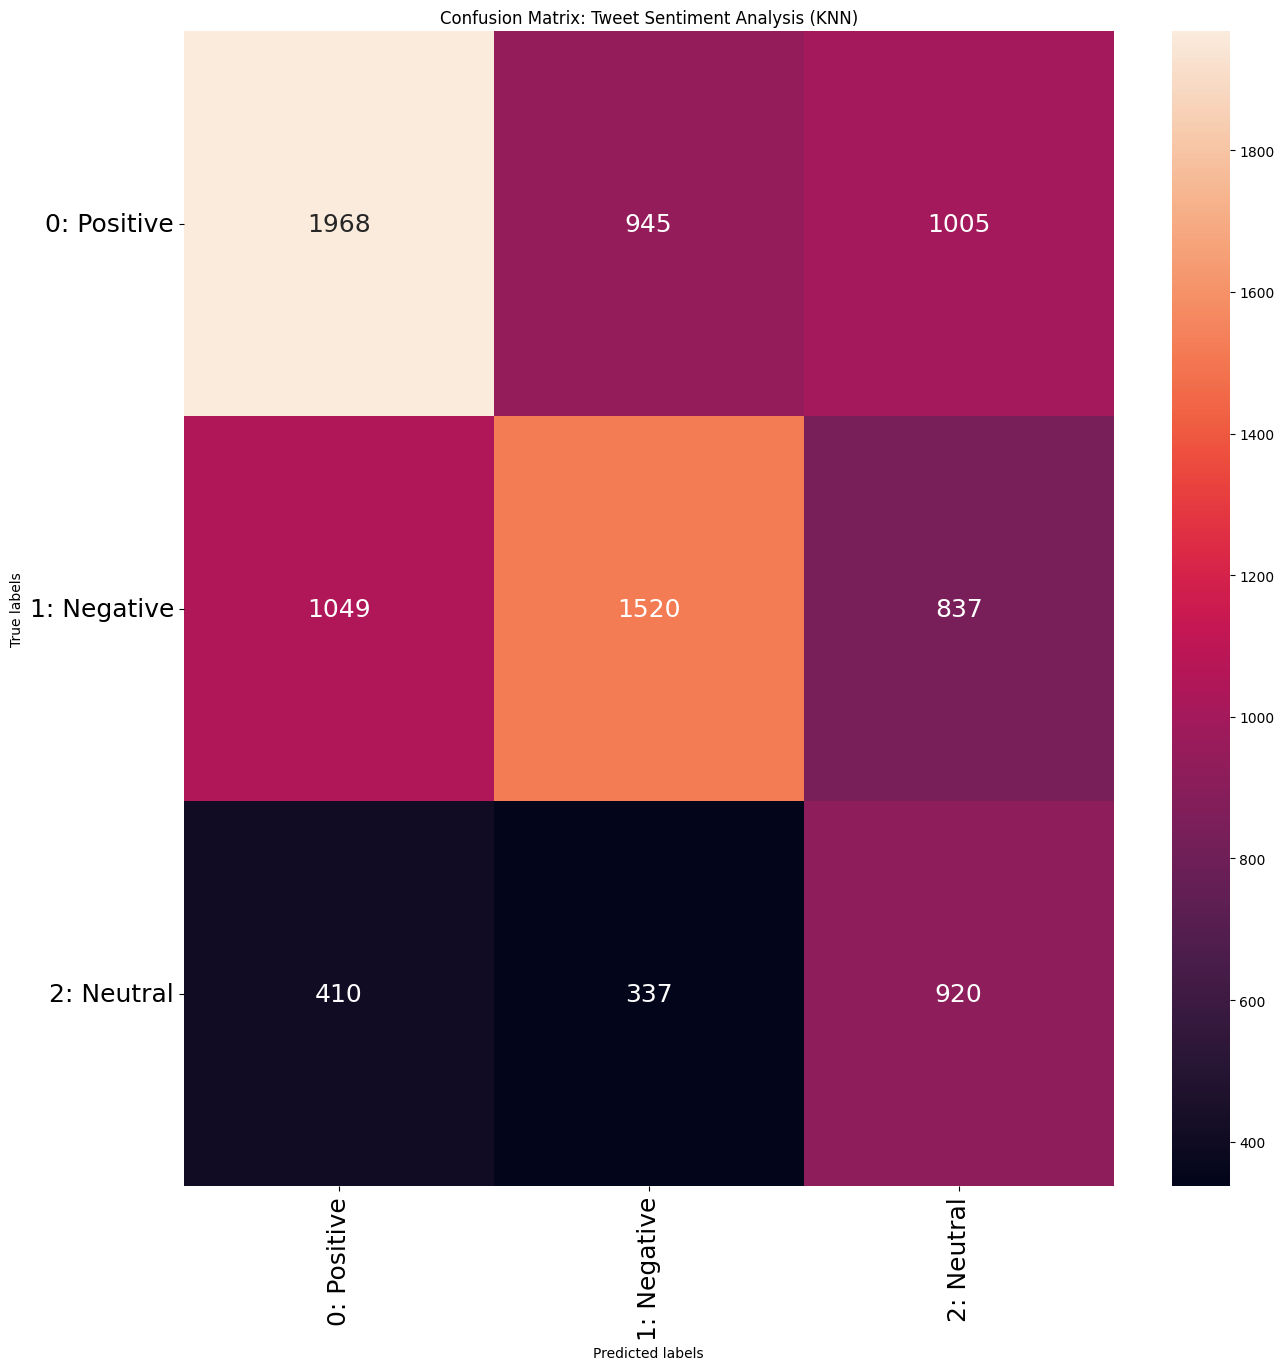

In [30]:
CM=confusion_matrix(y_pred=y_pred_test, y_true=test_labels)
print(CM)

## PLOT A PRETTY CONFUSION MATRIX
import seaborn as sns
import matplotlib.pyplot as plt     

# 0: Positive, 1: Negative, 2: Neutral
class_names = ["Positive","Negative","Neutral"]

fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(CM, annot=True, fmt='g', ax=ax, annot_kws={'size': 18})
#annot=True to annotate cells, ftm='g' to disable scientific notation
# annot_kws si size  of font in heatmap
# labels, title and ticks
ax.set_xlabel('Predicted labels') 
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix: Tweet Sentiment Analysis (KNN)') 
ax.xaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=90, fontsize = 18)

ax.yaxis.set_ticklabels(["0: Positive","1: Negative","2: Neutral"],rotation=0, fontsize = 18)